In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from uncertainties import ufloat
from uncertainties.umath import * 
from scipy.optimize import curve_fit
from scipy.integrate import trapz

import sys
sys.path.append('../src')  # Add the path to where the python scripts are located
from constants import *
from utils import *

In [2]:
# Esthetics for plots
nice_fonts = {
        # Use LaTeX to write all text
        "text.usetex": True,
        "font.family": 'serif',
        # Use 10pt font in plots, to match 10pt font in document
        "axes.labelsize": 18,
        "font.size": 18,
        "axes.linewidth":1,
        "axes.titlesize":16,
        # Make the legend/label fonts a little smaller
        "legend.fontsize": 13,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "ytick.major.size": 5,     # major tick size in points
        "ytick.minor.size": 3,       # minor tick size in points
        "xtick.major.size": 7,     # major tick size in points
        "xtick.minor.size": 3,       # minor tick size in points
        "xtick.major.width": 1.4,     # major tick width in points
        "xtick.minor.width": 1.4,     # minor tick width in points
}
mpl.rcParams.update(nice_fonts)

In [3]:
def S_ff_cylinder_new(nu, R, H, D, Te, n):

    '''Free-free spectrum from an homogeneous cylindrical region with radius and height equal to R.
    It assumes n_i = n_e = n.
    Formulae in Olnon 1975 ( https://articles.adsabs.harvard.edu/pdf/1975A%26A....39..217O )
    
    Input:
    nu = frequency in Hz
    R = source size in cm
    D = source distance in cm
    T_e = electron temperature in Kelvin
    n = gas density in cm^-3
    
    output:
    S_nu = flux density in Jy
    '''
    
    h = 6.6260755e-27
    c = 2.99792458e10
    k = 1.380658e-16
    pc = 3.08567758e18
    Jy = 1e23
    
    #Transform units
    nu_GHz = nu / 1e9 # Note that this is usually a vector of size m! 
    
    m = len(nu)
    
    fs = 8.235e-2 * Te**(-1.35) * nu_GHz**(-2.1) / pc # Eq.4 is in [cm^6 pc^-1]
#     cte_Snu = 2 * np.pi * k * Te * R**2 / (c**2 * D**2) # First part in Eq. 11
    ps = [2 * n**2 * H * f for f in fs] # Eq. 10
    Snu = []
    for i in range(m):
        if ps[i] > 1e-3:
            opac = 1. - np.exp(-ps[i])

        else:
            opac = ps[i]
#         S = cte_Snu * nu[i]**2 * opac * Jy # Eq. 11 Olnon 1975 for sphere (in Jy)
        cte_Snu = nBB(nu[i]/1E15, np.pi*R**2/(D**2), Te)
        S = cte_Snu * opac * Jy # Eq. 11 Olnon 1975 for sphere (in Jy)
        Snu.append(S)
    
    return Snu # in Jy

In [4]:
def CircumstellarDustExtinction(Snu_start,nu,Mdot_dust,vExp,Rin,Rout,kappaFile):
    
    from scipy import interpolate
    
    Rin = Rin*au
    Rout = Rout*au
    dustFolder = "../dust_opacities/"
    kappaIn = np.loadtxt(dustFolder+kappaFile,usecols=(0,1)).transpose()
    kappaIn[0] = (299792.458/kappaIn[0])*1E9
#     print(kappaIn)
    
#     kappa = np.interp(nu, kappaIn[0], kappaIn[1], left=None, right=None, period=None)
#     print(np.interp(1E15, kappaIn[0], kappaIn[1], left=None, right=None, period=None),kappaIn[1][-1])
    f = interpolate.interp1d(kappaIn[0], kappaIn[1])
    kappa = f(nu)
#     fig, ax = plt.subplots()
#     ax.plot(nu,kappa*1.1)
#     ax.plot(kappaIn[0],kappaIn[1])
#     ax.loglog()
#     plt.show()
    
    Mdot_dust = Mdot_dust*2E33/3.1536E7
    vExp = vExp * 1E3
    
    N_dust = Mdot_dust/(2*np.pi*vExp)*((1.0/Rin) - (1.0/Rout)) #in g/cm^2
#     print(N_dust, nu, kappa)
    tau  = kappa * N_dust
#     print(kappaIn[0],nu)
#     print(kappa)
#     print(tau)
    Snu_out = Snu_start*np.exp(-tau)
    
    return Snu_out
# nu  = np.logspace(10.5,18,101)
# Snu_ext = CircumstellarDustExtinction(np.zeros(nu.shape)+1.0,nu,1E-10,10.0,2,1E5,"0.09mu-0.11mu_MgFeSiO4_dens_HSD_new.opacity")
# fig, ax = plt.subplots()
# ax.plot(nu,np.zeros(nu.shape)+1.0)
# ax.plot(nu,Snu_ext)
# ax.loglog()
# plt.show()

In [5]:
def PlotModels(models,title,figureName):
    fig, ax = plt.subplots()
    plt.title(title)
    ax.set_xlabel(r'$\nu$ [Hz]')
    ax.set_ylabel(r'$S_\nu$ [Jy]')
    xmin, xmax = 1e11, 1e18
    # xmin, xmax = 5e11, 1e18
    ymin, ymax = 1e-5, 2e6
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    color_vector = np.linspace(0.05,0.95,len(models))
    colors = plt.cm.copper_r(color_vector) 
    # plt.plot(nu,S1)
    # SBB = Snu_BB(nu, T_beam, R_beam , D)
    # plt.plot(nu,SBB)
    for i in range(0,len(models)):

        plt.plot(models[i][0],models[i][1],label=models[i][2],color=colors[i])
    #     plt.plot(nu,Snu_BB,label=str(int(T_hots[i]))+" K (BB)",color=colors[i],ls='dotted')
    bands = [{'name': 'FUV', 'start': 1.947e15, 'width': 7.335e14, 'color': 'purple', 'pos': ymin + (ymax-ymin)/1E1},
         {'name': 'NUV', 'start': 1.295e15, 'width': 4.631e14, 'color': 'purple', 'pos': ymin + (ymax-ymin)/1E1},
         #{'name': 'U', 'start': 7.498e14, 'width': 1.0e14, 'color': 'violet', 'pos': ymin + (ymax-ymin)/2.},
         #{'name': 'B', 'start': 6.0e14, 'width': 1.0e14, 'color': 'blue', 'pos': ymin + (ymax-ymin)/5.},
         {'name': 'V', 'start': 5.0e14, 'width': 1.0e14, 'color': 'green', 'pos': ymin + (ymax-ymin)/10.},
         {'name': '300GHz', 'start': 3.0e11, 'width': 6.0e10, 'color': 'blue', 'pos': ymin + (ymax-ymin)/1E2},
         {'name': '950GHz', 'start': 9.5e11, 'width': 3.0e11, 'color': 'purple', 'pos': ymin + (ymax-ymin)/1E2},
         {'name': '9.8microns', 'start': 3.06e13, 'width': 1.0e13, 'color': 'purple', 'pos': ymin + (ymax-ymin)/1E9},
#          {'name': '9.8microns', 'start': 3.06e13, 'width': 1.0e13, 'color': 'purple', 'pos': ymin + (ymax-ymin)/10.},
    ]
    for band in bands:
        # Add the rectangle
        ax.add_patch(Rectangle((band['start'], ymin), band['width'], ymax-ymin,
                           edgecolor='none', facecolor=band['color'], alpha=0.1, lw=0))
        # Add the vertical dashed line with the text
        ax.axvline(band['start'] + band['width']/2, ymin=0, ymax=1, color=band['color'], alpha=0.2, linestyle='--')
        ax.text(band['start']*2.5, band['pos'], band['name'], color=band['color'],
            ha='right', va='center', rotation='vertical', fontsize=13)
#         ax.text(band['start'] + 3*band['width'], band['pos'], band['name'], color=band['color'],
#             ha='right', va='center', rotation='vertical', fontsize=13)

    ax.loglog() 
    ax.legend()
    plt.show()
    fig.savefig(figureName)

R_beam/R_s=4.986666666666666


/Users/theokhouri/Work/Studies/Free-Free_Santiago_Behzad/Git_Repo/AGB_hotspot-SED/ipynbs/../src/utils.py:18: RuntimeWarning: overflow encountered in exp
  return norm * 2. * h * (nu2**3/c**2) / ( np.exp(h*nu2/k_B/T) - 1. )


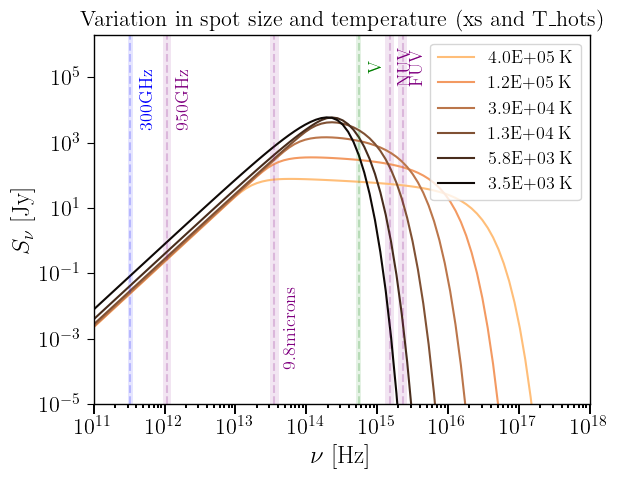

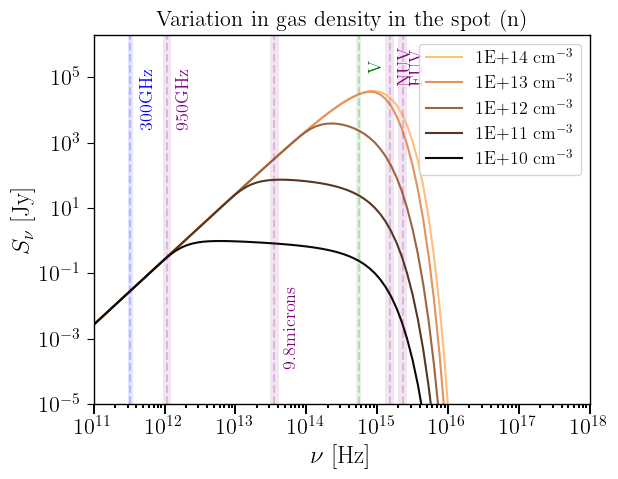

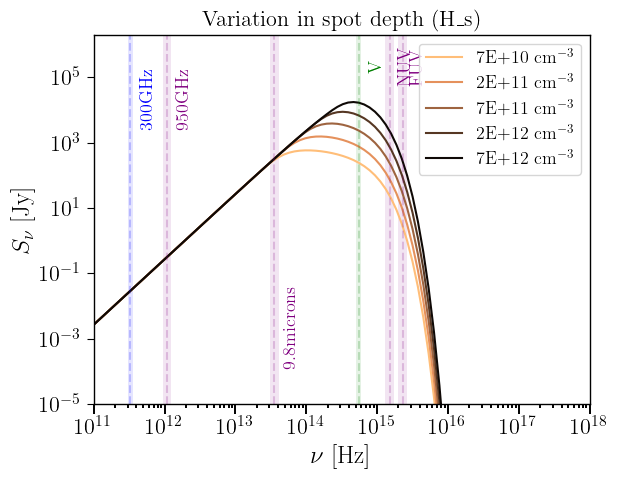

In [6]:
T_star = 2500 # K
T_beam = 3500 # K , measured brightness temperature in the beam with the hot spot
R_beam = 0.5 * au  # Beam size, to be updated
nu  = np.logspace(10.5,18,100)
R_s = 1.5E12
R_star = 2.5E13
# H_s = 1.5E11
H_s = R_beam*0.1
D   = 1.543e+20
#T   = 4E3
n   = 1E12
print(f'{R_beam/R_s=}')

# x is the normalized size of the hot spot
x_min = 0.05        # Arbitrary
x_max = 1.0        # R_beam/R_star

xs = np.geomspace(x_min, x_max, 6) 
# xs=np.asarray([0.1,0.28284,0.5,1.0])
color_vector = np.linspace(0.05,0.95,len(xs))
colors = plt.cm.copper_r(color_vector) 

# The temperature of the hot spot has to be consistent with the assumed stellar temperature 
# and the average temperature measured in the beam (T_beam). When x=x_max, T_hot = T_beam
T_hots = np.ones_like(xs) # just to have the same dimension
# i = 0
models = []
for i in range(0,len(xs)):
    T_hots[i] = T_star + (T_beam - T_star)/xs[i]**2
#     S_Jy_old = S_ff_cylinder(nu, R_beam*xs[i], H_s, D, T_hots[i], n)
#     S = [x * np.exp(-nu_i/nu_c) for (x,nu_i) in zip(S_Jy_old,nu)]
    S_Jy_new = S_ff_cylinder_new(nu, R_beam*xs[i], H_s, D, T_hots[i], n)
#     Snu_BB = nBB(nu/1E15, np.pi*1E23*(R_beam*xs[i]/D)**2.0, T_hots[i])
    models.append([nu,S_Jy_new,'%.1E' %T_hots[i]+" K"])

models2 = []
T_hotSpot = 15000.0
n_vec = [1E14,1E13,1E12,1E11,1E10]
xs_15000K = 0.28284
T_hots_15000K = T_star + (T_beam - T_star)/xs_15000K**2
for i in range(0,len(n_vec)):
    S_Jy = S_ff_cylinder_new(nu, R_beam*xs_15000K, H_s, D, T_hots_15000K, n_vec[i])
    models2.append([nu,S_Jy,'%.0E' % n_vec[i]+" cm$^{-3}$"])

models3 = []
H_s_range = [0.1,0.316,1.0,3.16,10.0]
for i in range(0,len(H_s_range)):
    S_Jy = S_ff_cylinder_new(nu, R_beam*xs_15000K, H_s*H_s_range[i], D, T_hots_15000K, n)
    models3.append([nu,S_Jy,'%.0E' % (H_s_range[i]*H_s)+" cm$^{-3}$"])
    
    
PlotModels(models,"Variation in spot size and temperature (xs and T_hots)","Fig_xs_and_Thots.pdf")
PlotModels(models2,"Variation in gas density in the spot (n)","Fig_density.pdf")
PlotModels(models3,"Variation in spot depth (H_s)","Fig_depth.pdf")

/Users/theokhouri/Work/Studies/Free-Free_Santiago_Behzad/Git_Repo/AGB_hotspot-SED/ipynbs/../src/utils.py:18: RuntimeWarning: overflow encountered in exp
  return norm * 2. * h * (nu2**3/c**2) / ( np.exp(h*nu2/k_B/T) - 1. )


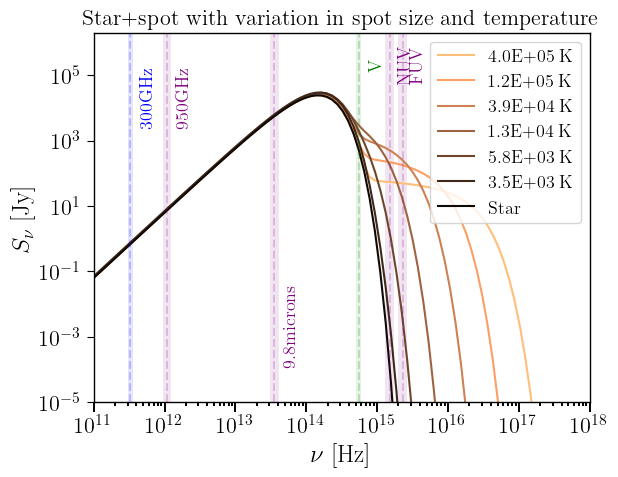

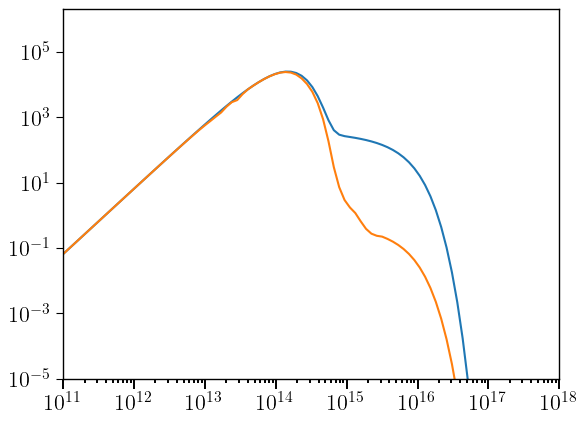

In [7]:
Snu_BBstar = nBB(nu/1E15, np.pi*1E23*(R_star/D)**2.0, T_star)
models4 = []
for model in models:
    models4.append([model[0],model[1] + Snu_BBstar,model[2]])

models4.append([nu,Snu_BBstar,"Star"])

PlotModels(models4,"Star+spot with variation in spot size and temperature","Fig_star+spot_xs_and_Thots.pdf")

Snu_ext = CircumstellarDustExtinction(models4[1][1],nu,2E-11,10.0,20,1E6,"0.09mu-0.11mu_MgFeSiO4_dens_HSD_new.opacity")
fig, ax = plt.subplots()
ax.plot(nu,models4[1][1])
ax.plot(nu,Snu_ext)
ax.loglog()
xmin, xmax = 1e11, 1e18
# xmin, xmax = 5e11, 1e18
ymin, ymax = 1e-5, 2e6
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

plt.show()